<a href="https://colab.research.google.com/github/Ry02024/EBProM/blob/main/EBProM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリのインポート

In [1]:
!git clone https://github.com/Ry02024/EBProM.git

Cloning into 'EBProM'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 3), reused 25 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 10.54 KiB | 10.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
%cd EBProM/Modules
!pip install jpholiday -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import calendar
from datetime import date, timedelta, datetime
import jpholiday
import csv
import random
import requests

from utils import *
from machine_learning import *
from simulation import *

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam, RMSprop

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, r2_score

import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping

pd.set_option('display.max_columns', 100)
%cd -

/content/EBProM/Modules


/content/EBProM/Modules/utils.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/content


# 前処理

## 前処理の実行（所要時間約2分）

In [3]:
# パスの設定
data_dir = "/content/EBProM/Data/"

# データ読み込み
sales_history_df, item_categories_df, category_names_df, test_df = load_data(data_dir)

# データの前処理
join_data_df = preprocess_data(sales_history_df, item_categories_df, category_names_df)

# 特徴量生成
join_data_df_final = generate_features(join_data_df)

# カタログデータを作成
catarog_df = complete_catalog(join_data_df_final)

# カタログデータのコピーを作成
catarog_df_copy = catarog_df.copy()

# 欠損値を補完
catarog_fill = fill_missing_values(catarog_df_copy, test_df)

# カタログデータを再コピー
catarog_copy = catarog_fill.copy()

# 特徴量をさらに補完
catarog_copy_feats1 = fill_features(catarog_copy)

# 補完された特徴量データをコピー
catarog_feats1_copy = catarog_copy_feats1.copy()

# 'month_target' 列を挿入 (値はすべて12)
catarog_feats1_copy.insert(1, 'month_target', 12)

# catarog_feats1_copy と test_df をキーで結合
test_data_extracted = catarog_feats1_copy.merge(test_df, left_on=['product_id', 'store_id'], right_on=['商品ID', '店舗ID'], how='inner')

# 必要に応じて列の整理（不要な列の削除など）を行う
test_data_extracted = test_data_extracted.drop(columns=['商品ID', '店舗ID'])

# データセットを訓練データ、検証データ、テストデータに分割
validation_df, train_df, test_df = split_train_validation_and_sort_test(catarog_feats1_copy, test_data_extracted)

データを読み込んでいます...
データの読み込みが完了しました。
データの前処理を開始します...
データの前処理が完了しました。
特徴量を生成しています...
特徴量の生成が完了しました。


100%|██████████| 18/18 [00:01<00:00, 14.67it/s]


欠損値を補完しています...
欠損値の補完が完了しました。
追加の特徴量を生成しています...


  0%|          | 0/9040 [00:00<?, ?it/s]/content/EBProM/Modules/utils.py:112: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5555555555555556' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  join_data_df10.loc[join_data_df10['product_id'] == product_id, 'product_ave_num'] = product_ave_num[product_id]
/content/EBProM/Modules/utils.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '356.1309209210279' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  join_data_df10.loc[join_data_df10['product_id'] == product_id, 'product_ave_price'] = product_ave_price[product_id]
  0%|          | 0/26 [00:00<?, ?it/s]/content/EBProM/Modules/utils.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ve

追加の特徴量生成が完了しました。


# 機械学習（LightGBMで22ヶ月のデータで学習）

## 学習用データの作成（モデルに入力するためにデータを整える）

In [4]:
lgb_train, lgb_eval = set_data_set(train_df, validation_df)

## 学習・検証（所要時間約30秒）

In [5]:
gbm = train_by_lightgbm(lgb_train, lgb_eval)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9454
[LightGBM] [Info] Number of data points in the train set: 159660, number of used features: 61
[LightGBM] [Info] Start training from score 0.509113
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.062446	valid_1's rmse: 0.0218527
Early stopping, best iteration is:
[63]	training's rmse: 0.16587	valid_1's rmse: 0.0189941


## 予測

In [6]:
# 予測
final_predicted = gbm.predict(test_df)

In [7]:
sub = pd.read_csv(data_dir + 'sample_submission.csv', header=None)

In [8]:
sub[1] = final_predicted

In [9]:
sub

,0,1
0,0,0.000666
1,1,0.000666
2,2,0.000666
3,3,8.988880
4,4,6.991028
...,...,...
3055,3055,2.996932
3056,3056,0.000666
3057,3057,0.000666
3058,3058,0.000666


In [10]:
# sub.to_csv(data_dir + 'ID100947_PBL01_ver24.csv', index=False, header=False)

# シミュレーション（去年の12月の実績と予測を比較）

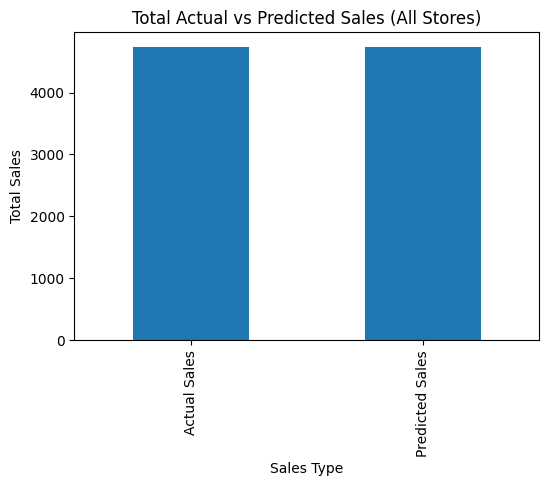

        Sales Type  Total Sales
0     Actual Sales  4739.000000
1  Predicted Sales  4734.541916


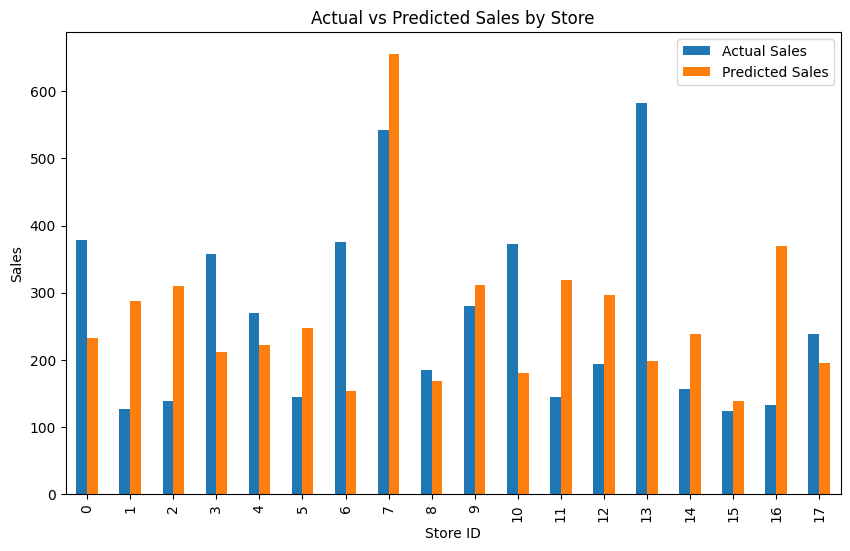

In [11]:
sim_visualize(join_data_df, test_df, sub)

現行精度※との比較：現行精度以上

        - 店舗あたり予実誤差（販売実績あり）
          現行精度 : 266個 → モデル精度 : 188.3個（小数点第2位を四捨五入）

        - 月間販売個数対比（販売実績あり）
          現行精度 : 約100% → モデル精度 : 89.5%（小数点第2位を四捨五入）

        - 店舗あたり予実誤差（販売実績なし）
          現行精度 : 73個 → モデル精度 : 74.7個（小数点第2位を四捨五入）

        - 月間販売個数対比（販売実績なし）
          現行精度 : 約240% → モデル精度 : 100.0%（小数点第2位を四捨五入）

AIモデル精度(RMSE)：4.19

In [12]:
from google.colab import drive
# Google Driveに記録を残す。
# Google Driveにマウント（接続）する。これにより、Colab上でGoogle Drive内のファイルにアクセスできるようになる。
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful